# 一、 加载Dataset数据集




In [ ]:
import json
with open("instruction-data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(data[1])
print(len(data))

# 二、 送训练 request和response格式

```javascript 

"Below is an instruction that describes a task."
"Write a response that appropriately completes the request."
"\n\n### Instruction:\n   instruction"

"\n\n### Input:\n input" 

 
"\n\n### Response:\noutput"
```


In [ ]:
def format_input(item):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{item['instruction']}"
    )

    input_text = f"\n\n### Input:\n{item['input']}" if item["input"] else ""

    return instruction_text + input_text

myinput = format_input(data[50])
response = f"\n\n### Response:\n{data[50]['output']}"
print(myinput+response)

# 三、 训练数据集、验证数据集、测试数据解的比列

训练数据集:80%

验证数据集:10%

测试数据集:10%

In [ ]:
#8:1:1
train_part = (int)(len(data) *0.8)
val_part = (int)(len(data)*0.1)
test_part = len(data)-train_part - val_part

train_data = data[:train_part]
val_data = data[train_part:train_part+val_part]
test_data = data[train_part+val_part:]

print("train set length:", len(train_data))
print("val set length:", len(val_data))
print("test set length:", len(test_data))

# 四、构建Dataset的数据集


In [ ]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.samples = []
        for i in data:
            input = format_input(i)
            response = f"\n\n### Response:\n{i['output']}"
            full_text = input + response
            self.samples.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.samples[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

In [ ]:
# import torch;

# def my_collate_fn(
#     batch,
#     pad_token_id=50256,
#     ignore_token_id=-100,
#     allowed_max_length=None, # 最大
#     device="cuda"  # 默认cpu设备
# ):
#     # 获取这个批次中最长样本的长度
#     batch_max_len = max(len(i) +1 for i in batch );

#     # 输入列表和目标列表
#     input_list, target_list = [], [];

#     for i in batch:
#         # 1. 将这个批次中小于批次最大长度的所有样本进行填充

#         # 2. 根据输入创建targets

#         # 3. 将targets中填充的token_id替换成-100(除了第一个的填充tokenid之外)
#         new_item = i + [pad_token_id];
#         padded = new_item +[pad_token_id] * (batch_max_len - len(new_item));

#         inputs = torch.tensor( padded[:-1]);
#         targets = torch.tensor(padded[1:]);

#         # targets  = [ 1 2 3   50256   50256 50256 ...]
#         # mask = [False, False, False True, True ...] 
#         mask = targets == pad_token_id;

#         slice = torch.nonzero(mask).sqeeze();
#         #slice = torch.nonzero(mask);
#         # 不只一个大于1
#         if slice.numel() > 1:
#             targets[slice[1:]] = ignore_token_id;

#         if allowed_max_length is not None:
#             inputs = inputs[:allowed_max_length];
#             targets = targets[:allowed_max_length];

#         input_list.append(inputs);
#         target_list.append(targets);

#     input_tensor = torch.stack(input_list).to(device);

#     target_tensor = torch.stack(target_list); # .to(device);

#     return input_tensor, target_tensor;


def my_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_token_id=-100,
    allowed_max_length=None,
    device="cpu"
):
    #获取这个批次中最长样本的长度
    batch_max_len = max(len(i)+1 for i in batch)
    #bacth_max_len = max(len(i)+1 for i in batch)
    input_list, target_list = [], []

    for i in batch:
        #将这个批次中小于批次最大长度的所有样本进行填充
        #根据输入创建targets
        #将targets中填充的token_id替换成-100（除第一个填充的tokenid之外）
        new_item = i + [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_len - len(new_item))
        #padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # targets = [1 2 3 50256 50256 ...],
        # mask = [False, False, False, True, True ...]
        mask = targets == pad_token_id
        slice = torch.nonzero(mask).squeeze()
        if slice.numel() > 1:
            targets[slice[1:]] = ignore_token_id
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        input_list.append(inputs)
        target_list.append(targets)

    inputs_tensor = torch.stack(input_list).to(device)
    #targets_tensor = troch.stack(target_list)
    targets_tensor = torch.stack(target_list)

    return inputs_tensor, targets_tensor

In [ ]:
# test_mask = [False, True, False, True, True, False, True, True];
# # 打印非 False的下标
# print(torch.nonzero(torch.tensor(test_mask)));
# # 二维变一维
# slice = torch.nonzero(torch.tensor(test_mask)).squeeze();
# print(slice);


# targets = torch.tensor([1, 34, 4, 5, 6, 50256, 50256, 50256]);
# # 前面三项不动 改变后面的数字
# targets[slice[1:]] = -100;
# print(targets)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from functools import partial
customized_collate_fn = partial(my_collate_fn, 
                                device=device,
                                allowed_max_length=1024)
print(device)

# 五、加载 训练、验证数据集

In [ ]:
#  加载数据集
from torch.utils.data import DataLoader

batch_size=8

torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = True,
    drop_last = True
)

#验证数据集
val_dataset = InstructionDataset(val_data, tokenizer)
val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = False,
    drop_last = False
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = False,
    drop_last = False
)

# 六、加载OpenAi-GPT2模型

In [ ]:
from GPTModel import MyGPTModel, generate_new, text_to_tokenids, tokenids_to_text
from load_gpt2_model import load_gpt2_weights
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "max_seq_length": 1024,
    "embedding_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True
};
model = MyGPTModel(GPT_CONFIG_124M)

load_gpt2_weights(model, GPT_CONFIG_124M)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"模型已加载至：{device}")


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai-community/gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<HTTPSConnection(host='huggingface.co', port=443) at 0x1619ca66050>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 1e42ddc3-ea9d-48bd-b864-ec0f603f6a80)')' thrown while requesting HEAD https://huggingface.co/openai-community/gpt2/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai-community/gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<HTTPSConnection(host='huggingface.co', port=443) at 0x1619ca67460>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 08aaf6ba-5122-444c-9b3d-8b592549b0a0)')' thrown while requesting HEAD https://huggingface.co/openai-community/gpt2/resolve/main/config.json
Retrying in 4s [Retry 3/5].


[2/3] 开始权重移植...
  -> 正在加载 Embeddings (wte, wpe)...
  -> 正在加载 12 层 Transformer Block...
  -> 正在加载 Final LayerNorm & Head...
[3/3] 成功！GPT-2 权重已全部加载完成。

模型已加载至：cuda


#  八、 加载模型 推理demo


In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
prompt = "OpenAI is"
prompt = text_to_tokenids(prompt, tokenizer).to(device)
tokens = generate_new(model, 
             prompt,
             30,
             GPT_CONFIG_124M["max_seq_length"],
             25,
             1.2)

print(f"output:{tokenids_to_text(tokens, tokenizer)}")

output:OpenAI is the first game to be built specifically for the platform. It's based on a popular AI software, and includes tools for building games to be played on


# 九、 指令微调

In [12]:
from GPTModel import calc_loss
with torch.no_grad():
        train_loss = calc_loss(train_dataloader, model, device)
        val_loss = calc_loss(val_dataloader, model, device)


print("Training loss:", train_loss);
print("Validation loss:", val_loss);

Training loss: tensor(4., device='cuda:0')
Validation loss: tensor(4., device='cuda:0')


In [13]:
from GPTModel import train_model;
import time;



start_time = time.time();

torch.manual_seed(123);

# 优化器设置
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.001);


epochs = 2;

train_loss, val_loss = train_model(model, 
           train_dataloader,
           val_dataloader,
            optimizer=optimizer, 
            device=device,
            epochs=epochs,
            tokenizer=tokenizer,
            eval_interval=5,
            
            prompt=format_input(val_data[0]),)


end_time = time.time();

duration = (end_time-start_time)/60;
print(f"Traning Finished, in{duration:.2f} minutes.");


Epoch1 step:         5: Train loss 1.000, Eval loss1.000
Epoch1 step:        10: Train loss 1.000, Eval loss1.000
Epoch1 step:        15: Train loss 1.000, Eval loss1.000
Epoch1 step:        20: Train loss 1.000, Eval loss1.000
Epoch1 step:        25: Train loss 1.000, Eval loss1.000
Epoch1 step:        30: Train loss 0.000, Eval loss1.000
Epoch1 step:        35: Train loss 0.000, Eval loss1.000
Epoch1 step:        40: Train loss 0.000, Eval loss1.000
Epoch1 step:        45: Train loss 0.000, Eval loss1.000
Epoch1 step:        50: Train loss 0.000, Eval loss1.000
Epoch1 step:        55: Train loss 0.000, Eval loss1.000
Epoch1 step:        60: Train loss 0.000, Eval loss1.000
Epoch1 step:        65: Train loss 0.000, Eval loss1.000
Epoch1 step:        70: Train loss 0.000, Eval loss1.000
Epoch1 step:        75: Train loss 0.000, Eval loss1.000
Epoch1 step:        80: Train loss 0.000, Eval loss1.000
Epoch1 step:        85: Train loss 0.000, Eval loss1.000
Epoch1 step:        90: Train l

#  保存模型到文件


In [14]:
torch.save(model.state_dict(), "model_sft.pth");

# 绘制损失趋势图

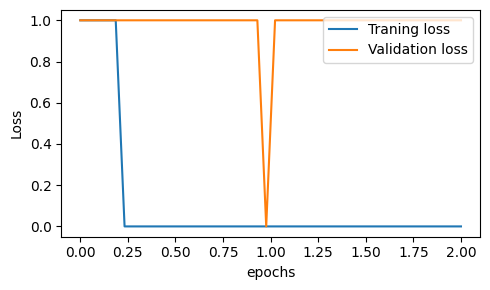

In [15]:
import matplotlib.pyplot as  plt;


def to_numpy(tensor):
    """Safely convert any tensor to numpy array"""
    return tensor.detach().cpu().numpy()

def plot_loss(epochs, train_loss, val_loss ):
    fig, ax = plt.subplots(figsize=(5, 3));
    ax.plot(epochs, train_loss  , label="Traning loss");
    ax.plot(epochs, val_loss , label="Validation loss");
    ax.set_xlabel("epochs");
    ax.set_ylabel("Loss");
    ax.legend(loc="upper right");
    fig.tight_layout();

x = torch.linspace(0, epochs, len(train_loss) );
# 方法2：列表推导式（最常用）
train_loss_cpu_list = [tensor.cpu() for tensor in train_loss];
val_loss_cpu_list = [tensor.cpu() for tensor in val_loss];
plot_loss(x,  (train_loss_cpu_list),  (val_loss_cpu_list));

# 十、使用自己训练模型推理



In [16]:
torch.manual_seed(123)
for entry in test_data[:3]:                #A
    input_text = format_input(entry)
    token_ids = generate_new(model,
        text_to_tokenids(input_text, tokenizer).to(device),
        256,
        GPT_CONFIG_124M["max_seq_length"],
        25,
        1.0,
        50256)
    generated_text = tokenids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:","").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Explain the primary function of the human heart.

Correct response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary purpose of the heart is to supply the hungry children with the bus. It causes the movement at the base and affect ecosystems by moving at sea level.
-------------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Reword the following sentence to the future tense.

### Input:
He is reading a novel inspired by his grandmother.

Correct response:
>> He will be reading a novel inspired by his grandmother.

Model response:
>> He was reading a novel.
-------------------------------------
Below is an instruction

#  十一、模型评分


## 生成评分测试数据

In [20]:
from tqdm import tqdm
from GPTModel import generate_new

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate_new(
        model=model,
        prompt=text_to_tokenids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_seq_size=GPT_CONFIG_124M["max_seq_length"],
        eos_id=50256
    )
    generated_text = tokenids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:",
"").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4) # "indent" for pretty-printing

100%|██████████| 110/110 [00:20<00:00,  5.49it/s]


In [21]:
import json;
import urllib.request;


def chat_model(prompt, model="qwen3:latest", url="http://192.168.9.179:11434/api/chat"):
    data = {
         "model": model,
        "messages": [
            {
                "role": "user", 
                "content": prompt
            }
        ],
        "options": {
            "seed": 123,
            "temperature": 0.0
        }
    };

    payload = json.dumps(data).encode("utf-8");
    request = urllib.request.Request(url, method="POST", data=payload);
    request.add_header("Content-Type", "application/json");
    content = "";
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode('utf-8');
            if not line:
                break;

            response_json = json.loads(line);
            # print(f"response_json:{response_json}");
            content +=response_json["message"]["content"];
        return content;
 


In [25]:
result = chat_model("你好，你是谁？")
print(result)

你好！我是通义千问，是通义实验室研发的超大规模语言模型。我能够帮助你回答问题、创作文字、逻辑推理、编程等，我的目标是让每个人都能便捷地使用人工智能技术。虽然我没有个人情感，但我可以提供帮助和陪伴。有什么问题或需要协助的吗？😊


# 评分代码实现


In [27]:
with open("instruction-data-with-response.json", "r", encoding="utf-8") as f:
    jsondata = json.load(f)
#print(data[0])  
for entry in jsondata[:3]:
    prompt = (
        f" 给定一个输入： `{format_input(entry)}` "
        f" 正确的输出为: `{entry['output']}`, "
        f" 模型给的输出为： `{entry['model_response']}`"
        f" 请为模型的输出打分，0表示最差，100表示最好，只给出分数。"
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", chat_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary function of the heart is to supply the body with oxygen through breathing.

Score:
>> 0

-------------------------

Dataset response:
>> He will be reading a novel inspired by his grandmother.

Model response:
>> He is reading a book.

Score:
>> 0

-------------------------

Dataset response:
>> The government passed the law.

Model response:
>> The law was passed by the government.

Score:
>> 0

-------------------------


## 测试评分

In [28]:
from tqdm import tqdm
def generate_model_scores(json_data):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"给定一个输出： `{format_input(entry)}` "
            f"正确的输出为: `{entry['output']}`, "
            f"模型给的输出为： `{entry['model_response']}`"
            f" 请为模型的输出打分，0表示最差，100表示最好，只给出分数。"                       
        )
        score = chat_model(prompt)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(jsondata)
print(f"Number of scores: {len(scores)} of {len(jsondata)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [24:15<00:00, 13.23s/it]

Number of scores: 110 of 110
Average score: 10.09



In [29]:
print(f"Number of scores: {len(scores)} of {len(jsondata)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Number of scores: 110 of 110
Average score: 10.09

